<div class="alert alert-block alert-warning">
<b>Alert:</b> This QPU calculation costs $ ??? .
</div>

<div class="alert alert-block alert-success">
<b>This simulation runs a circuit with a classical implementation of path integral monte carlo. </b>
<div>Obs. 1: The data is saved in external files so that it can be worked on without incurring new costs.</div>
<div>Obs. 2: For new simulation parameters, save in a file with a different name.</div>
</div>

# Instructions if you are running outside AWS cloud

1. Install aws-cli:

`sudo apt install aws-cli`

2. Setup aws credentials:

`aws configure --profile "default"`

3. Create virtual environment 

`python -m venv /path/to/new/virtual/environment`

4. Activate virtual environment

`source /path/to/new/virtual/environment/bin/activate`

In [ ]:
# Install this modules on your virtual environment: an open source library for interacting
# with quantum computing devices and simulators on Amazon Braket
!pip install amazon-braket-sdk
!pip install boto3

### AWS login

In [4]:
from boto3 import Session
from braket.aws import AwsSession

# Start Boto3 Session with your credentials profile
boto_session = Session(profile_name="default")

# Initialize Braket session with Boto3 Session credentials
aws_session = AwsSession(boto_session=boto_session)

# Importing modules

In [5]:
from braket.tracking import Tracker

t = Tracker().start()

In [6]:
# AWS imports: Import Braket SDK modules
import math

from braket.circuits import Circuit, Observable
from braket.devices import LocalSimulator

In [8]:
from braket.aws import AwsDevice, AwsQuantumTask
from braket.error_mitigation import Debias

# Integrais de Caminho e Função de Partição no Oscilador Harmônico Quântico

## Introdução

Em mecânica estatística quântica, a função de partição é uma ferramenta fundamental para descrever o comportamento térmico de um sistema quântico em equilíbrio. Para sistemas simples, a função de partição pode ser calculada exatamente a partir dos autovalores do Hamiltoniano. No entanto, para sistemas mais complexos, o cálculo analítico torna-se inviável, e precisamos recorrer a métodos numéricos. Um desses métodos é o das integrais de caminho, auxiliado por simulações de Monte Carlo.

## Definição da Função de Partição
A função de partição canônica é dada por:

$$
Z = \mathrm{Tr}(e^{-\beta \hat{H}})
$$

onde $\beta = \frac{1}{k_B T}$ e $\hat{H}$ é o Hamiltoniano do sistema.

## Representação por Integrais de Caminho
Em termos de integrais de caminho, podemos escrever:

$$
Z = \int \mathcal{D}[x(\tau)] e^{-S_E[x(\tau)]}
$$

A ação euclidiana no tempo imaginário é:

$$
S_E[x(\tau)] = \int_0^\beta d\tau \left[\frac{m}{2} \left(\frac{d x}{d \tau}\right)^2 + V(x(\tau))\right]
$$

onde $m$ é a massa da partícula e $V(x)$ é o potencial que governa o sistema. Sabendo que utilizando o tempo como uma variável imaginária o sinal do potencial muda de negativo para positivo em decorrência.

## Oscilador Harmônico Quântico
Para o potencial harmônico:

$$
V(x) = \frac{1}{2}m\omega^2 x^2
$$

A função de partição exata é conhecida:

$$
Z = \frac{e^{-\frac{1}{2} \beta \hbar \omega}}{1 - e^{-\beta \hbar \omega}}
$$

Esse resultado exato é útil para compararmos com as aproximações numéricas.

## Aproximação Monte Carlo
Podemos estimar $Z$ numericamente por Monte Carlo:

$$
Z \approx \frac{1}{N_{\text{caminhos}}} \sum_{\text{caminhos aceitos}} e^{-S_E[x]}
$$

Esse método consiste em gerar amostras estocásticas de caminhos $x(\tau)$ no espaço imaginário do tempo, utilizando um algoritmo de Monte Carlo com o critério de aceitação de Metropolis. A cada passo, uma pequena perturbação é feita em um ponto do caminho atual, e o novo caminho é aceito com uma probabilidade que depende da variação da ação euclidiana $S_E[x]$. Após um grande número de amostras, a média dos pesos $e^{-S_E[x]}$ fornece uma estimativa da função de partição.

## Energia Média
A energia média pode ser obtida a partir de $Z$:

$$
\langle E \rangle = -\frac{\partial \ln Z}{\partial \beta}
$$

Outra forma prática, pela energia média dos caminhos:

$$
\langle E \rangle \approx \frac{1}{N_{\text{caminhos}}} \sum_{\text{caminhos aceitos}} E[x]
$$

Com:

- Energia cinética média:

$$
E_{\text{cinética}} = \frac{m}{2} \left\langle \left(\frac{dx}{d\tau}\right)^2 \right\rangle
$$

- Energia potencial média:

$$
E_{\text{potencial}} = \left\langle \frac{m \omega^2}{2} x(\tau)^2 \right\rangle
$$

- Energia total do caminho:

$$
E[x] = E_{\text{cinética}} + E_{\text{potencial}}
$$

## Descrição Completa do Método

1. **Discretização do tempo imaginário:** Dividimos o intervalo $[0, \beta]$ em $P$ pontos discretos igualmente espaçados.
2. **Inicialização:** Começamos com um caminho inicial $x(\tau) = 0$ para todos os pontos.
3. **Monte Carlo:** Em cada passo do algoritmo:
   - Escolhemos aleatoriamente um dos pontos discretos do caminho.
   - Realizamos uma pequena alteração no valor da posição $x_j \rightarrow x_j + \delta$, com $\delta$ sendo um valor aleatório dentro de um intervalo definido.
   - Calculamos a variação na ação euclidiana $\Delta S_E$ resultante dessa alteração.
   - Aplicamos o critério de Metropolis:
     - Se $\Delta S_E < 0$, aceitamos a alteração.
     - Se $\Delta S_E > 0$, aceitamos com probabilidade $e^{-\Delta S_E}$.
4. **Amostragem:** Repetimos esse processo por um grande número de passos e armazenamos os caminhos aceitos.
5. **Estimativa de $Z$:** Calculamos a função de partição como a média dos pesos $e^{-S_E[x]}$ dos caminhos aceitos.
6. **Cálculo da Energia:** Calculamos a energia média avaliando a energia cinética e potencial em cada caminho aceito e fazendo a média aritmética.

Esse método é especialmente útil em sistemas onde a solução exata não é conhecida, permitindo uma aproximação numérica confiável da função de partição e das propriedades termodinâmicas do sistema.


### Parâmetros do Sistema

- $\beta$ é o inverso da temperatura em unidades naturais $\left(\beta = \frac{1}{k_B T}\right)$.
- $P$ é o número de divisões do intervalo de tempo imaginário $[0, \beta]$.
- $\epsilon = \beta / P$ é o tamanho de cada "passo" no tempo imaginário.
- Assumimos $\hbar = 1$ pra simplificar as contas (unidades naturais).

Esse **"tempo imaginário"** é um truque da mecânica quântica estatística para calcular a função de partição como uma soma de trajetórias.


In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros do sistema
beta = 5.0  # inverso da temperatura, 
P = 100  # Número de pontos na discretização do caminho
eps = beta / P  # tamanho do passo em tau
m = 1.0 # massa
omega = 1.0 # velocidade angular

### Função da Ação Euclidiana

Essa função calcula a **Ação Euclidiana** discretizada em tempo imaginário:

$$
S_E[x(\tau)] = \int_0^\beta d\tau \left[ \frac{m}{2} \left(\frac{dx}{d\tau}\right)^2 + \frac{m\omega^2}{2} x(\tau)^2 \right]
$$

No código, como estamos **discretizando** o caminho em $P$ pontos:

- **A parte cinética** é aproximada como diferenças finitas:
  
  $$
  \left(\frac{dx}{d\tau}\right)^2 \sim \frac{(x_{j+1} - x_j)^2}{\epsilon^2}
  $$

- **A parte potencial** avalia $x(\tau)^2$ em cada ponto e soma.

Então a ação $S(x)$ é a soma dessas duas partes.


In [43]:
# Função ação euclidiana discreta
def S(x):
    kinetic = 0.5 * m * np.sum((x[1:] - x[:-1])**2) / eps
    potential = 0.5 * m * omega**2 * np.sum(x**2) * eps
    return kinetic + potential

### Energia Média do Caminho

- **A energia média** é a soma da energia cinética e da potencial ao longo do caminho.
- O fator $1 / P$ faz a média ao longo dos $P$ pontos.

Lembrando que **isso é diferente da ação**:
- **Ação** é uma integral no tempo imaginário.
- **Energia** é uma média da energia em cada instante.


In [34]:
def energia_caminho(x):
    kinetic = 0.5 * m * np.sum((x[1:] - x[:-1])**2) / (eps * P)  # cinética média
    potential = 0.5 * m * omega**2 * np.sum(x**2) * eps / P  # potencial média
    return kinetic + potential

### Monte Carlo para Gerar Caminhos

- Gera **caminhos aleatórios** usando o algoritmo de Metropolis:
  1. Escolhe **um ponto do caminho** e **muda um pouco**.
  2. Calcula a **variação na ação** $\Delta S$.
  3. **Aceita sempre** se a ação diminuir.  
     **Se aumentar**, aceita com probabilidade $e^{-\Delta S}$ (aleatoriedade).

- Guarda **energias**, **pesos** e **caminhos** de tempos em tempos.

Esse método **"caminha" pelos caminhos prováveis** de acordo com o peso $e^{-S}$.


In [35]:
# Monte Carlo
n_passos = 50000
delta = 0.5  # tamanho máximo dos passos aleatórios

x = np.zeros(P)  # caminho inicial (reta x=0)
amostras = []

for i in range(n_passos):
    # Escolhe um ponto aleatório pra tentar mudar
    j = np.random.randint(0, P)
    x_new = x.copy()
    x_new[j] += np.random.uniform(-delta, delta)

    dS = S(x_new) - S(x)
    if dS < 0 or np.random.rand() < np.exp(-dS):
        x = x_new

    if i % 100 == 0:
        amostras.append(x.copy())

### Estimativa por Pesos

Isso aqui é a média dos pesos $e^{-S(x)}$, ou seja:

$$
Z \approx \left\langle e^{-S[x]} \right\rangle
$$


In [36]:
Z_pesos = np.mean(pesos)

### Estimativa pela Energia Média

Aqui estamos usando:

$$
Z \approx e^{-\beta \langle E \rangle}
$$

Essa fórmula vem da relação:

$$
\langle E \rangle = -\frac{\partial \ln Z}{\partial \beta}
$$

Válida em sistemas grandes e bem amostrados.


In [37]:
energia_media = np.mean(energias)
Z_energia = np.exp(-beta * energia_media)

### Solução Analítica

Essas fórmulas vêm da solução analítica do oscilador harmônico quântico.


In [38]:
Z_exato = np.exp(-0.5 * beta * hbar * omega) / (1 - np.exp(-beta * hbar * omega))
E_exato = 0.5 * hbar * omega + hbar * omega / (np.exp(beta * hbar * omega) - 1)


# Exibindo resultados
print(f"Função de Partição Exata Z_exato = {Z_exato:.4f}")
print(f"Função de Partição Monte Carlo (Energia Média) Z_energia ≈ {Z_energia:.4f}")
print(f"Energia Média Exata E_exato = {E_exato:.4f}")
print(f"Energia Média Monte Carlo ⟨E⟩ ≈ {energia_media:.4f}")

Função de Partição Exata Z_exato = 0.0826
Função de Partição Monte Carlo (Energia Média) Z_energia ≈ 0.0812
Energia Média Exata E_exato = 0.5068
Energia Média Monte Carlo ⟨E⟩ ≈ 0.5021


### Visualização dos Caminhos

Isso plota alguns caminhos gerados durante a simulação.

Você consegue ver que eles ficam oscilando em torno de x=0, porque esse é o valor de equilíbrio do oscilador harmônico.

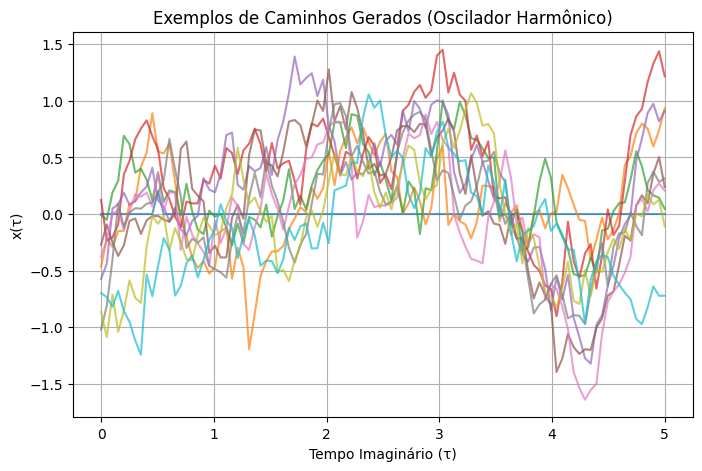

In [39]:
# Visualizando alguns caminhos gerados
plt.figure(figsize=(8, 5))
for i in range(0, len(amostras), len(amostras) // 10):
    plt.plot(np.linspace(0, beta, P), amostras[i], alpha=0.7)

plt.title("Exemplos de Caminhos Gerados (Oscilador Harmônico)")
plt.xlabel("Tempo Imaginário (τ)")
plt.ylabel("x(τ)")
plt.grid(True)
plt.show()